Makemore imitation in Python

In [625]:
import torch
import pandas as pd
import math

df = pd.read_csv('player_info.csv')
#must make strings all lowercase and replace all spaces with '%'
words = (df['player_name'].map(str.lower)).to_list()
words = [i.replace(' ','%') for i in words]

In [626]:
min(len(w) for w in words)

4

In [627]:
max(len(w) for w in words)

24

Creating a Bigram Language Model. Weak and simple model that uses two letters at a time to predict the nect letter in the sequence.

In [628]:
for w in words[:1]:
    for ch1, ch2 in zip(w,w[1:]): #zip pairs two iterators and iterators over each until one list ends
        print(ch1,ch2)

d e
e n
n n
n i
i s
s %
% r
r o
o d
d m
m a
a n


In [629]:
b = {}
for w in words:
    chs = ['<>']+list(w)+['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0)+1

In [630]:
sorted(b.items(), key = lambda kv:kv[1])
#gives counts of frequency for each pair in the dataset

[(('u', 'x'), 1),
 (('k', 'c'), 1),
 (('c', 'p'), 1),
 (('f', 'm'), 1),
 (('v', 'k'), 1),
 (('c', 'f'), 1),
 (('l', 'r'), 1),
 (('-', 'm'), 1),
 (('h', 'j'), 1),
 (('z', 'd'), 1),
 (('x', 's'), 1),
 (('j', 's'), 1),
 (('y', 'j'), 1),
 (('-', 't'), 1),
 (('o', '-'), 1),
 (('k', 'z'), 1),
 (('t', '-'), 1),
 (('m', 'f'), 1),
 (('x', 'l'), 2),
 (('b', 'h'), 2),
 (('s', 'd'), 2),
 (('p', 't'), 2),
 (('c', 'm'), 2),
 (('u', 'u'), 2),
 (('m', 'g'), 2),
 (('l', 'z'), 2),
 (('v', 't'), 2),
 (('-', 'o'), 2),
 (('c', 'n'), 2),
 (('-', 'h'), 2),
 (('q', 'i'), 2),
 (('.', 'p'), 2),
 (('s', 'v'), 2),
 (('c', 's'), 2),
 (('-', 'd'), 2),
 (('d', 't'), 3),
 (('r', 'h'), 3),
 (('d', 'k'), 3),
 (('g', 'k'), 3),
 (('e', '-'), 3),
 (('w', 'v'), 3),
 (('m', 'j'), 3),
 (('k', 'j'), 3),
 (('g', 'b'), 3),
 (('m', 'n'), 3),
 (('-', 'l'), 3),
 (('s', 'r'), 3),
 (('h', 's'), 3),
 (('g', 'f'), 4),
 (('b', '.'), 4),
 (('p', 'm'), 4),
 (('p', 'u'), 4),
 (('t', 'd'), 4),
 (('b', 'n'), 4),
 (('q', 'y'), 4),
 (('h', '-

From here you start using pytorch to create arrays to better handle the data

In [631]:
N = torch.zeros((31,31),dtype=torch.int32) #30 is the letters of the alphabet + ' ' + '.' + two special char

In [632]:
chars = sorted(list(set(''.join(words)))) 
#list of the set of all lowercase character, set keeps them from having double values
stoi = {s:i for i,s in enumerate(chars)}
stoi['<>'] = 30 #start/end of words
len(chars), len(stoi)

(30, 31)

In [633]:
for w in words:
    chs = ['<>']+ list(w) +['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

In [824]:
itos = {i:s for s,i in stoi.items()}
itos #map of the index of each char in the stoi list

{0: '%',
 1: "'",
 2: '-',
 3: '.',
 4: 'a',
 5: 'b',
 6: 'c',
 7: 'd',
 8: 'e',
 9: 'f',
 10: 'g',
 11: 'h',
 12: 'i',
 13: 'j',
 14: 'k',
 15: 'l',
 16: 'm',
 17: 'n',
 18: 'o',
 19: 'p',
 20: 'q',
 21: 'r',
 22: 's',
 23: 't',
 24: 'u',
 25: 'v',
 26: 'w',
 27: 'x',
 28: 'y',
 29: 'z',
 30: '<>'}

(-0.5, 30.5, 30.5, -0.5)

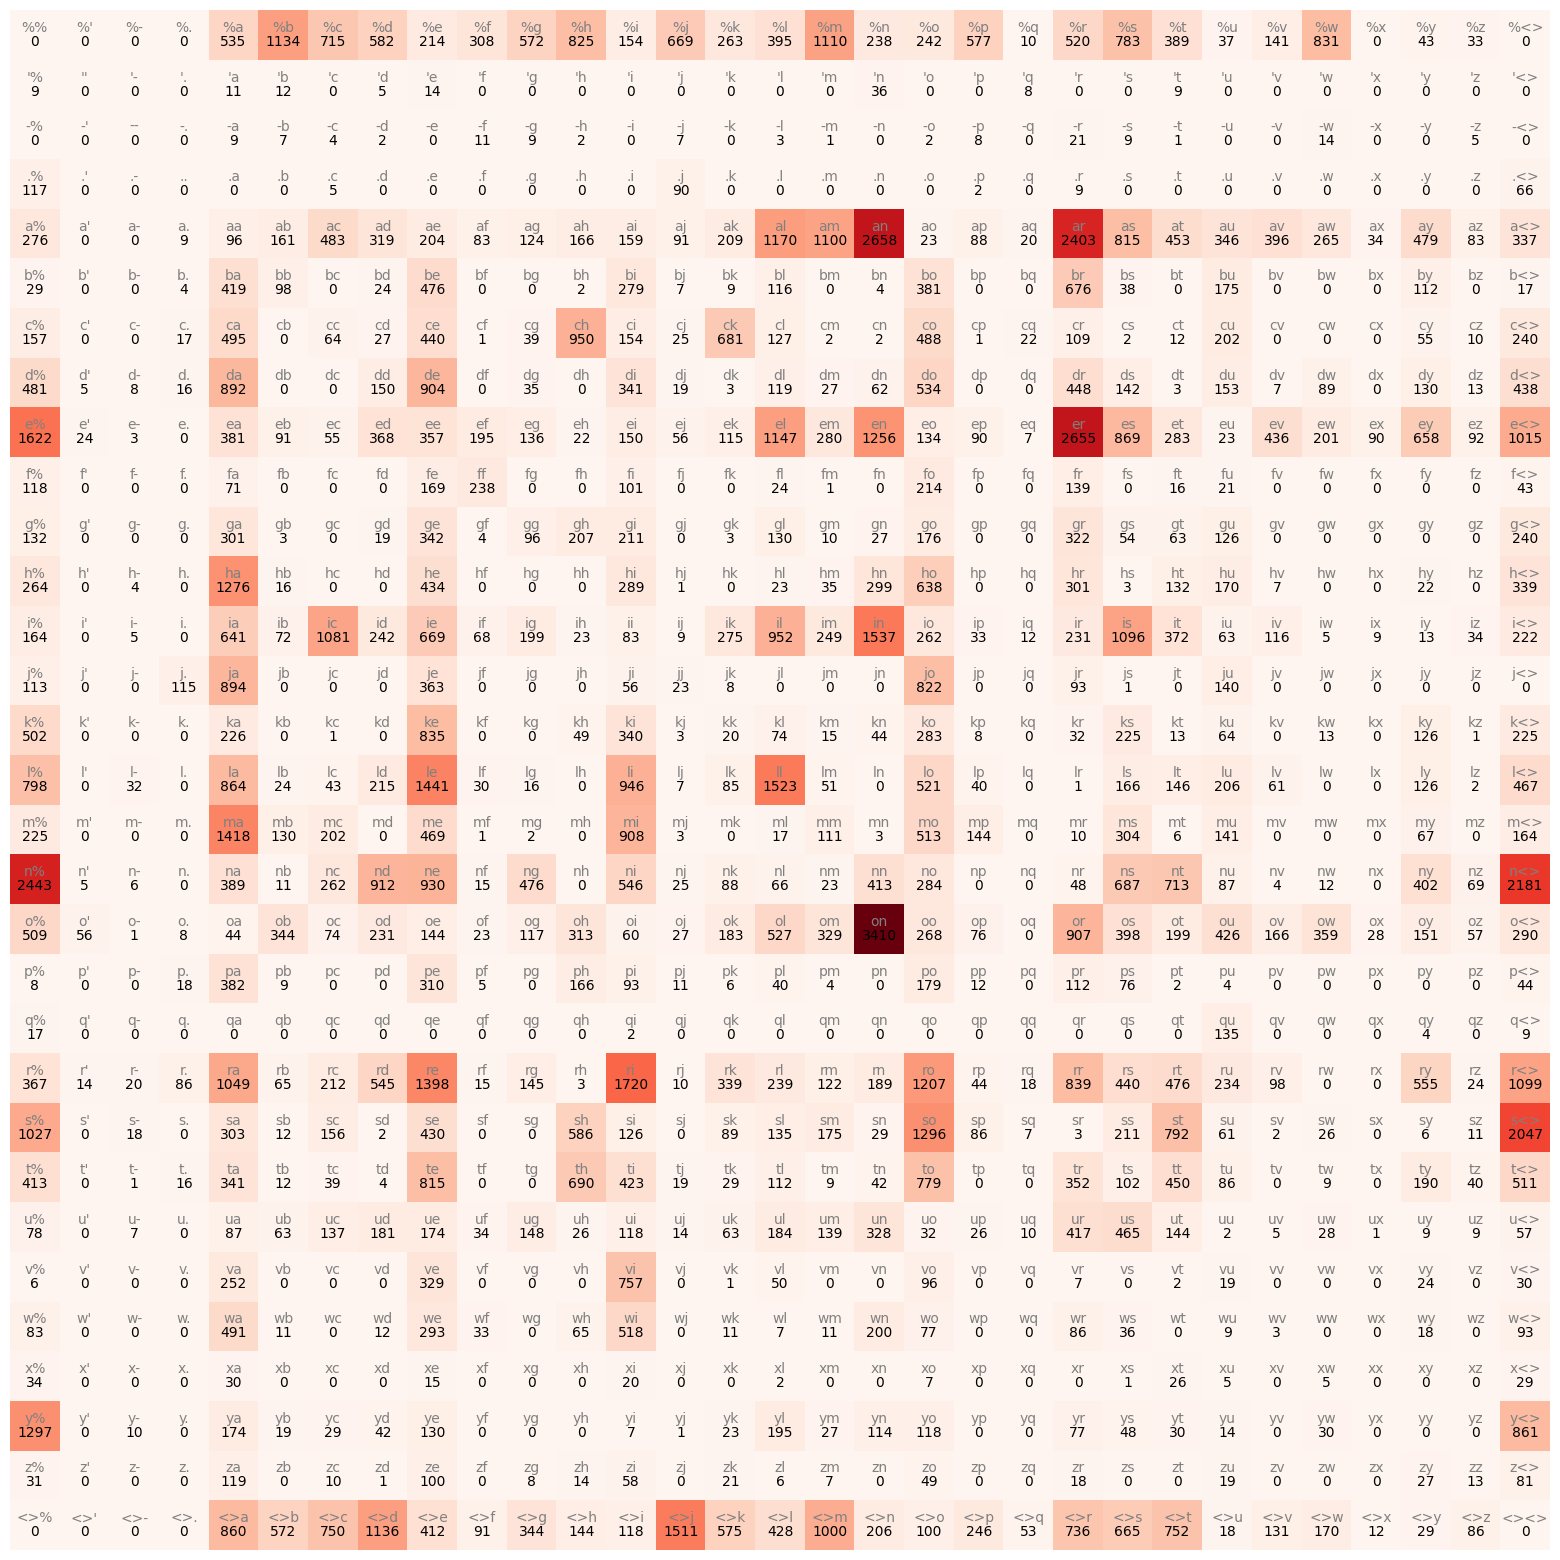

In [825]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(N,cmap='Reds')
for i in range(31):
    for j in range(31):
        chstr = str(itos[i]+itos[j])
        #print(itos[i])
        plt.text(j,i,chstr,ha='center',va='bottom',color='gray')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='black')
plt.axis('off')

Now you convert raw counts to probabilities to use as weights in the model

In [826]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0473, 0.1002, 0.0632, 0.0514, 0.0189,
        0.0272, 0.0505, 0.0729, 0.0136, 0.0591, 0.0232, 0.0349, 0.0981, 0.0210,
        0.0214, 0.0510, 0.0009, 0.0459, 0.0692, 0.0344, 0.0033, 0.0125, 0.0734,
        0.0000, 0.0038, 0.0029, 0.0000])

Torch.multinomial produces integers across a probability distribution - a Generator is then used to make everything deterministic

In [827]:
g = torch.Generator().manual_seed(2147483647)
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0473, 0.1002, 0.0632, 0.0514, 0.0189,
        0.0272, 0.0505, 0.0729, 0.0136, 0.0591, 0.0232, 0.0349, 0.0981, 0.0210,
        0.0214, 0.0510, 0.0009, 0.0459, 0.0692, 0.0344, 0.0033, 0.0125, 0.0734,
        0.0000, 0.0038, 0.0029, 0.0000])

In [828]:
ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
itos[ix] #drop first char (check also on graph above for probability)

'n'

To check next character u move along the row and generate the next value dependent on the probabilities calculated. The loop to do this is shown below. Keep in mind, everytime you run the 'IN[184]:' you recieve a different output!

This sucks, but that's because it takes so little information into account (only preceding letter)

In [829]:
P = (N+1).float() #+1 makes nothing entirely impossible, keeping -log prob from being inf!

#this step is called model smoothing

P = P / P.sum(1,keepdim=True) #keepdim=True keeps the shape of the array instead of outputting just the sum of the row
#important!!! Remember keepdim is False by default 
#1 is the axis on which we are summing to get P.sum
#the / stretches the P.sum matrix which is (1,30) across the (30,30) P matrix

for i in range(8): #how many names to generate
    ix = 0
    out = []

    while True:
        p = P[ix]
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        if itos[ix] == '%':
            itos[ix] = ' '
        out.append(itos[ix])
        if ix == 30:
            break
    print(''.join(out))

suacus minitous<>
lewan<>
hnten<>
cha min<>
jo<>
cone palleren elevichantron<>
lerele<>
tis hahu bdep<>


Check the probability of each model generation

In [830]:
for w in words:
    chs = ['<>']+ list(w) +['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        print(f'{ch1}{ch2}: {prob:.4}')

<>d: 0.1017
de: 0.1792
en: 0.09788
nn: 0.0372
ni: 0.04916
is: 0.1251
s%: 0.1341
%r: 0.0459
ro: 0.1041
od: 0.02378
dm: 0.005545
ma: 0.2914
an: 0.2033
n<>: 0.1961
<>d: 0.1017
dw: 0.01782
wa: 0.2356
ay: 0.03669
yn: 0.03509
ne: 0.08366
e%: 0.1264
%s: 0.06907
sc: 0.02048
ch: 0.2185
hi: 0.06769
in: 0.1754
nt: 0.06416
tz: 0.007434
zi: 0.09625
iu: 0.007299
us: 0.1545
s<>: 0.2671
<>e: 0.03695
ea: 0.02975
ar: 0.1838
rl: 0.02068
l%: 0.1019
%c: 0.06308
cu: 0.04663
ur: 0.1385
re: 0.1206
et: 0.02211
to: 0.1414
on: 0.3496
n<>: 0.1961
<>e: 0.03695
ed: 0.02873
d%: 0.09545
%o: 0.02141
o': 0.005843
'b: 0.0963
ba: 0.145
an: 0.2033
nn: 0.0372
no: 0.02561
on: 0.3496
n<>: 0.1961
<>e: 0.03695
ed: 0.02873
d%: 0.09545
%p: 0.05092
pi: 0.06217
in: 0.1754
nc: 0.02363
ck: 0.1567
kn: 0.01438
ne: 0.08366
ey: 0.05132
y<>: 0.263
<>e: 0.03695
ed: 0.02873
dd: 0.0299
di: 0.06772
ie: 0.07641
e%: 0.1264
%j: 0.05903
jo: 0.3095
oh: 0.03219
hn: 0.07003
ns: 0.06183
so: 0.1692
on: 0.3496
n<>: 0.1961
<>e: 0.03695
ed: 0.02873
dd: 

Here you use the likelihood -- which is the product of each of the probabilities! Good models have high likelihoods... no shieeet --> For convenience you use the log likelihood which is the log of likelihood which transforms it monotonically to a value from -infinity to 1!

In [831]:
for w in words[:3]:
    chs = ['<>']+ list(w) +['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4}')

<>d: 0.1017 -2.285
de: 0.1792 -1.719
en: 0.0979 -2.324
nn: 0.0372 -3.291
ni: 0.0492 -3.013
is: 0.1251 -2.079
s%: 0.1341 -2.009
%r: 0.0459 -3.081
ro: 0.1041 -2.262
od: 0.0238 -3.739
dm: 0.0055 -5.195
ma: 0.2914 -1.233
an: 0.2033 -1.593
n<>: 0.1961 -1.629
<>d: 0.1017 -2.285
dw: 0.0178 -4.027
wa: 0.2356 -1.445
ay: 0.0367 -3.305
yn: 0.0351 -3.35
ne: 0.0837 -2.481
e%: 0.1264 -2.068
%s: 0.0691 -2.673
sc: 0.0205 -3.888
ch: 0.2185 -1.521
hi: 0.0677 -2.693
in: 0.1754 -1.741
nt: 0.0642 -2.746
tz: 0.0074 -4.902
zi: 0.0962 -2.341
iu: 0.0073 -4.92
us: 0.1545 -1.868
s<>: 0.2671 -1.32
<>e: 0.0370 -3.298
ea: 0.0297 -3.515
ar: 0.1838 -1.694
rl: 0.0207 -3.878
l%: 0.1019 -2.284
%c: 0.0631 -2.763
cu: 0.0466 -3.065
ur: 0.1385 -1.977
re: 0.1206 -2.116
et: 0.0221 -3.812
to: 0.1414 -1.956
on: 0.3496 -1.051
n<>: 0.1961 -1.629


The reason to use log is that log(a*b*c)=log(a)+log(b)+log(c)...

In [832]:
log_likelihood = 0.0
n = 0 #simple count
for w in ['dennis rodman']:#words[:3]: #testing with a real name...
    chs = ['<>']+ list(w) +['<>']
    chs = [i.replace(' ','%') for i in chs]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
print(f'{log_likelihood=}') #this can range from low to 0

log_likelihood=tensor(-35.4534)


However, to use on loss function to better visualise the minimization of loss you make the log_likelihood negative so that the closer your value is to 0, the better the accuracy of your model. You can also normalise log_likelihood by the to get an even more clear metric.

In [833]:
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

nll=tensor(35.4534)
nll/n=tensor(2.5324)


You can input every output into the likelihood checker to evaluate the quality of each output, and average it over large samples to check the overall quality of the model. 
THIS BIGRAM MODEL IS FINISHED and limited as is

Next step is to use a Neural Network on the Bigram model to create similar outputs!

NEXT STEP is to create the training set of bigrams...

In [916]:
xs,ys = [],[]
for w in words[:1]:
    chs = ['<>']+list(w)+['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        #print(ch1,ch2)
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:',num) #the amount of bigrams in "dennis rodman" when w[:1]

number of examples: 14


A common way of encoding integers is called one-hot encoding, which requires an integer to become a vector wherein only the matrix index at the int in question is given the value of the int. 3 --> [0,0,1]

torch has something called... torch.nn.functional.one_hot()

In [917]:
import torch.nn.functional as f
xenc = f.one_hot(xs, num_classes= 31).float()
xenc.shape

torch.Size([14, 31])

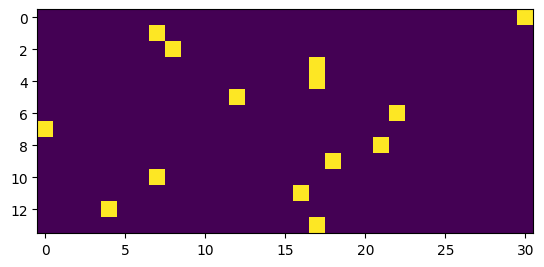

In [937]:
plt.imshow(xenc)

In [938]:
W = torch.randn((31,31)) #create same amount of neurons as classes
xenc @ W #multiplication

tensor([[-3.6655e-01,  1.4529e+00,  9.7289e-01,  7.9257e-02, -1.3850e+00,
          1.6690e+00,  2.5919e-01, -1.1420e+00, -2.0201e+00,  2.0256e-01,
          1.5590e+00,  1.1156e-01, -1.0418e+00, -1.9503e-01, -1.1595e+00,
          9.7729e-01,  2.0087e+00,  6.1049e-01,  8.0500e-01, -4.6270e-01,
          2.9694e-01, -2.3189e-01, -1.5656e-01,  1.1168e+00, -8.6054e-02,
         -5.0731e-01, -1.5454e+00, -1.7862e-02,  5.0503e-01,  5.8741e-01,
          6.0186e-01],
        [ 5.2198e-01,  3.2699e-01,  2.1343e+00,  6.2662e-01,  1.2727e+00,
          1.1109e+00,  9.8983e-01,  1.3413e+00, -7.0699e-01, -4.4064e-01,
          8.1553e-01, -4.4930e-01,  6.7105e-01, -3.5868e-01,  6.0732e-01,
          7.2612e-01, -1.3305e+00, -1.8390e+00, -8.5324e-02,  7.0712e-02,
         -6.5073e-01, -4.7852e-01, -1.3905e+00, -1.3268e-01, -2.5374e+00,
         -4.5850e-01, -1.1628e+00, -6.7186e-01,  8.9643e-01,  7.9475e-01,
          2.7588e-01],
        [-5.3766e-01,  1.8932e+00,  5.9111e-01, -9.6327e-02,  5.81

In [939]:
(xenc @ W)[3,13] #firing rate of 13th neuron at the 3rd input
#(xenc[3] * W[:,13]).sum() #is the same exact operation

tensor(-0.3536)

To make these figures easier to process you make exponentiate them as to make them all positive. Makes the data as interpretave as the counts we had in the graph before. Positive numbers, all above 0...

In [956]:
logits = xenc @ W #log-counts
counts = logits.exp() #equibalent N
probs = counts / counts.sum(1,keepdims=True)
# probs[0].sum() ALWAYS EQUALS 1 when it's normalised

To do this properly you must initialise 27 neuron weights, each neuron receives 31 inputs

In [957]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((31,31),generator=g)

In [958]:
xenc = f.one_hot(xs,num_classes=31).float() #input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() #set counts equivalent to N
probs = counts / counts.sum(1, keepdims=True)#probabilities for next character
#counts and probs lines are called a 'selfmax'

In [959]:
probs.shape

torch.Size([14, 31])

In [960]:
nlls = torch.zeros(14)
for i in range(14):
    #i-th in bigram
    x = xs[i].item() #input character index
    y = ys[i].item() #label character index
    print(f'\n bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('ouptut probabilities from the neural net:', probs[i])
    print('label (actual next char):',y)
    p = probs[i,y]
    print('probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('\n=============')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())


 bigram example 1: <>d (indexes 30,7)
input to the neural net: 30
ouptut probabilities from the neural net: tensor([0.0268, 0.0239, 0.0240, 0.0335, 0.0230, 0.1425, 0.0393, 0.0266, 0.0095,
        0.0263, 0.0294, 0.0214, 0.0194, 0.0231, 0.0291, 0.0348, 0.0033, 0.0083,
        0.0425, 0.0079, 0.0577, 0.0270, 0.0068, 0.0083, 0.0233, 0.0093, 0.0178,
        0.1124, 0.0335, 0.0052, 0.1038])
label (actual next char): 7
probability assigned by the net to the correct character: 0.026552828028798103
log likelihood: -3.6286189556121826
negative log likelihood: 3.6286189556121826

 bigram example 2: de (indexes 7,8)
input to the neural net: 7
ouptut probabilities from the neural net: tensor([0.0170, 0.0709, 0.0288, 0.0778, 0.0069, 0.0089, 0.0250, 0.0101, 0.0140,
        0.0059, 0.0689, 0.0037, 0.0128, 0.0072, 0.0179, 0.0156, 0.0660, 0.0106,
        0.0395, 0.0369, 0.1416, 0.0141, 0.0208, 0.0344, 0.0441, 0.0041, 0.0176,
        0.0818, 0.0156, 0.0254, 0.0562])
label (actual next char): 8
probabil

Lower the loss the better the performance of the prediction. 

The best setting can be found using gradient-based optimisation to find the setting of the W generated matrix that minimizes the amount of loss. The neural net here is one single layer followed by a soft max, which makes it relatively easy to operate on... 

Using backpropogation to evaluate loss and do OPTIMIZATION - on whole dataset

In [994]:
xs,ys = [],[]
for w in words:
    chs = ['<>']+list(w)+['<>']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples:',num) #the amount of bigrams in "dennis rodman" when w[:1]

number of examples: 153808


In [995]:
xs,ys

(tensor([30,  7,  8,  ..., 16,  4, 22]),
 tensor([ 7,  8, 17,  ...,  4, 22, 30]))

In [996]:
#initializing network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((31,31),generator=g,requires_grad=True)#last piece is crucial for back prop

In [1010]:
#gradient descent
for k in range(100):

    #forward pass
    xenc = f.one_hot(xs,num_classes=31).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(153808),ys].log().mean()
    print(loss.item())

    #backward pass
    W.grad = None #setting gradient equal to zero
    loss.backward()

    #update
    W.data += -5.50 * W.grad #the value here is the learning rate

2.5531556606292725
2.5506155490875244
2.5484840869903564
2.5466902256011963
2.545175552368164
2.5438930988311768
2.5428054332733154
2.5418801307678223
2.5410921573638916
2.5404202938079834
2.539846181869507
2.5393550395965576
2.538935422897339
2.5385754108428955
2.538267135620117
2.5380027294158936
2.537775993347168
2.537580966949463
2.5374138355255127
2.5372705459594727
2.537147045135498
2.537040948867798
2.536949396133423
2.5368709564208984
2.5368030071258545
2.5367443561553955
2.536693811416626
2.5366501808166504
2.5366125106811523
2.5365796089172363
2.536550998687744
2.5365262031555176
2.5365045070648193
2.5364856719970703
2.536468982696533
2.536454200744629
2.5364413261413574
2.5364298820495605
2.536419630050659
2.5364105701446533
2.5364022254943848
2.5363945960998535
2.5363881587982178
2.536381721496582
2.5363759994506836
2.5363709926605225
2.5363664627075195
2.5363619327545166
2.5363576412200928
2.536353588104248
2.5363500118255615
2.536346435546875
2.5363430976867676
2.53633975

Finally you sample from the neural net

In [1011]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = f.one_hot(torch.tensor([ix]),num_classes=31).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1,keepdim=True)

        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        out.append(itos[ix])
        if ix == 30:
            break
    print(''.join(out))

n<>
pacut'nstitous<>
lewan<>
hnten<>
cha min<>
